<a href="https://colab.research.google.com/github/7yl4r/0ad-unit-net/blob/master/03_seagrass_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seagrass Analysis

We want to understand how seagrass communities in the Florida Keys National Marine Sanctuary change over time, and what environmental factors may drive those changes. We also want to detect any abnormal changes or events that might indicate ecological issues (e.g., die-offs, blooms)

#Data collection


In [ ]:
!pip install pyobis pygbif pandas folium

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import os
project_dir = '/content/drive/MyDrive/GSoC_SDM_Project'
if not os.path.exists(project_dir):
    os.makedirs(project_dir)

Mounted at /content/drive


In [ ]:
from pyobis import occurrences as obis_occurrences
from pyobis import taxa
from pygbif import occurrences as gbif_occurrences, species as gbif_species
import pandas as pd
import time


In [ ]:
seagrass_names = [
    "Halodule wrightii",
    "Halophila engelmannii",
    "Thalassia testudinum",
    "Halophila decipiens",
    "Syringodium filiforme"
]

In [ ]:
def get_obis_occurrences_by_taxaids(taxa_ids, area_bbox=None, limit=10000):
    """
    Download occurrence data from OBIS by taxon ID list.
    Returns a dataframe with lat, lon, time columns.
    """
    frames = []
    for tid in taxa_ids:

        query = obis_occurrences.search(taxonid=tid, size=limit)
        if area_bbox:
            bbox = area_bbox
            geom = f"POLYGON(({bbox[0]} {bbox[1]},{bbox[2]} {bbox[1]},{bbox[2]} {bbox[3]},{bbox[0]} {bbox[3]},{bbox[0]} {bbox[1]}))"
            query = obis_occurrences.search(taxonid=tid, size=limit, geometry=geom)
        query.execute()

        try:
            df = query.to_pandas()
        except Exception:
            continue

        if set(['decimalLongitude', 'decimalLatitude', 'eventDate']).issubset(df.columns):
            frames.append(df[['decimalLongitude', 'decimalLatitude', 'eventDate']].rename(
                columns={'decimalLongitude': 'lon', 'decimalLatitude': 'lat', 'eventDate': 'time'}
            ))
    if frames:
        return pd.concat(frames, ignore_index=True)
    return pd.DataFrame(columns=['lon', 'lat', 'time'])

Pulling GBIF Data

In [ ]:
def get_gbif_data(scientific_names, area_bbox=None, limit_per_species=1000):
    """
    scientific_names: list of taxon scientific names
    area_bbox: [min_lon, min_lat, max_lon, max_lat]
    Returns combined pandas DataFrame with columns lat, lon, time
    """
    frames = []
    for name in scientific_names:
        params = {
            'scientificName': name,
            'limit': limit_per_species,
            'hasCoordinate': True,
        }
        if area_bbox:
            params['decimalLatitude'] = f"{area_bbox[1]},{area_bbox[3]}"
            params['decimalLongitude'] = f"{area_bbox[0]},{area_bbox[2]}"
        results = gbif_occurrences.search(**params)
        data = results['results']
        if data:
            df = pd.DataFrame(data)
            if set(['decimalLongitude', 'decimalLatitude', 'eventDate']).issubset(df.columns):
                frames.append(df[['decimalLongitude', 'decimalLatitude', 'eventDate']].rename(
                    columns={'decimalLongitude':'lon', 'decimalLatitude':'lat', 'eventDate':'time'}
                ))
        time.sleep(1)
    if frames:
        return pd.concat(frames, ignore_index=True)
    return pd.DataFrame(columns=['lon', 'lat', 'time'])


In [ ]:
obis_taxa_ids = [143769, 143770, 143751, 143768, 234030]
florida_keys_bbox = [-82, 24, -80, 25]


In [ ]:

gbif_df = get_gbif_data(seagrass_names, area_bbox=florida_keys_bbox)
gbif_df.shape


(1500, 3)

In [ ]:
obis_df = get_obis_occurrences_by_taxaids(obis_taxa_ids, area_bbox=florida_keys_bbox)
obis_df.shape

(1566, 3)

Combining OBIS and GBIF data

In [ ]:
combined_df = pd.concat([obis_df, gbif_df], ignore_index=True)
combined_df = combined_df.drop_duplicates().dropna(subset=['lat', 'lon', 'time']).reset_index(drop=True)
print("Combined OBIS + GBIF data:", combined_df.shape)
combined_df.head()

Combined OBIS + GBIF data: (353, 3)


,lon,lat,time
0,-80.649250,24.996280,2006-10-05T12:50
1,-80.870448,24.992606,2021-05
2,-80.822806,24.964519,2021-05
3,-80.500000,24.500000,1998
4,-80.835571,24.966715,2021-05


#Data Cleaning & Preprocessing

In [ ]:
import pandas as pd




combined_df = combined_df.drop_duplicates()


combined_df = combined_df.dropna(subset=['lat', 'lon', 'time'])


combined_df['time'] = pd.to_datetime(combined_df['time'], errors='coerce')
combined_df = combined_df.dropna(subset=['time'])
combined_df['year'] = combined_df['time'].dt.year

combined_df = combined_df[combined_df['year'] >= 2000]

combined_df = combined_df.reset_index(drop=True)

combined_df.shape
combined_df.head()


,lon,lat,time,year
0,-80.649250,24.996280,2006-10-05 12:50:00,2006
1,-80.834916,24.979066,2006-10-06 12:01:00,2006
2,-80.883433,24.998600,2005-04-19 12:46:00,2005
3,-80.832800,24.968517,2006-05-03 12:21:00,2006
4,-80.849766,24.987616,2005-04-19 13:20:00,2005


In [ ]:
combined_df.shape

(176, 4)

# Bringing Environmental data

In [ ]:
!pip install xarray netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.0 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm

salinity_file = f'{project_dir}/cmems_salinity_44d2_bc4b_70b2_U1749495233099.nc'
ds = xr.open_dataset(salinity_file)

sal_lats = ds['latitude'].values
sal_lons = ds['longitude'].values
sal_times = pd.to_datetime(ds['time'].values)

def get_nearest_salinity_spatial(row, ds, lons, lats, varname='so'):
    lon_idx = np.abs(lons - row['lon']).argmin()
    lat_idx = np.abs(lats - row['lat']).argmin()
    try:
        value = ds[varname].isel(time=0, latitude=lat_idx, longitude=lon_idx).values.item()

        if hasattr(value, 'mask') and value.mask:
            return np.nan
        if np.isnan(value):
            return np.nan
        return value
    except Exception as e:
        return np.nan

tqdm.pandas()
combined_df['salinity'] = combined_df.progress_apply(
    lambda row: get_nearest_salinity_spatial(row, ds, sal_lons, sal_lats, varname='so'),
    axis=1
)


print("\n")
print(combined_df[['lon', 'lat', 'time', 'salinity']].head())
print(combined_df['salinity'].describe())


100%|██████████| 176/176 [00:00<00:00, 950.96it/s]



         lon        lat                time   salinity
0 -80.649250  24.996280 2006-10-05 12:50:00  37.025467
1 -80.834916  24.979066 2006-10-06 12:01:00  36.981316
2 -80.883433  24.998600 2005-04-19 12:46:00  36.918724
3 -80.832800  24.968517 2006-05-03 12:21:00  36.981316
4 -80.849766  24.987616 2005-04-19 13:20:00  36.981316
count    170.000000
mean      36.913815
std        0.152664
min       36.367954
25%       36.918724
50%       36.981316
75%       36.981316
max       37.025467
Name: salinity, dtype: float64


Adding Temparature

In [ ]:
temp_file = f'{project_dir}/woa23_decav_t00_04.nc'
ds_temp = xr.open_dataset(temp_file, decode_times=False)

print(ds_temp)
print(ds_temp.data_vars)

<xarray.Dataset> Size: 5GB
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * depth               (depth) float32 408B 0.0 5.0 10.0 ... 5.4e+03 5.5e+03
  * time                (time) float32 4B 4.614e+03
Dimensions without coordinates: nbounds
Data variables: (12/14)
    crs                 int32 4B ...
    lat_bnds            (lat, nbounds) float32 6kB ...
    lon_bnds            (lon, nbounds) float32 12kB ...
    depth_bnds          (depth, nbounds) float32 816B ...
    climatology_bounds  (time, nbounds) float32 8B ...
    t_an                (time, depth, lat, lon) float32 423MB ...
    ...                  ...
    t_sd                (time, depth, lat, lon) float32 423MB ...
    t_se                (time, depth, lat, lon) float32 423MB ...
    t_oa                (time, depth, lat

In [ ]:
temp_var = 't_an'  # annual mean temperature
lat_name = 'lat'
lon_name = 'lon'

temp_lats = ds_temp[lat_name].values
temp_lons = ds_temp[lon_name].values


ds_temp_surf = ds_temp[temp_var].isel(time=0, depth=0)



In [ ]:
def get_nearest_temp_spatial(row, temp_grid, lons, lats):
    lon_idx = np.abs(lons - row['lon']).argmin()
    lat_idx = np.abs(lats - row['lat']).argmin()
    try:
        value = temp_grid[lat_idx, lon_idx].values.item()
        if hasattr(value, 'mask') and value.mask:
            return np.nan
        if np.isnan(value):
            return np.nan
        return value
    except Exception:
        return np.nan


In [ ]:
combined_df['temperature'] = combined_df.progress_apply(
    lambda row: get_nearest_temp_spatial(row, ds_temp_surf, temp_lons, temp_lats),
    axis=1
)
print("\n")

print(combined_df[['lon', 'lat', 'time', 'salinity', 'temperature']].head())
print(combined_df['temperature'].describe())


100%|██████████| 176/176 [00:00<00:00, 1284.81it/s]



         lon        lat                time   salinity  temperature
0 -80.649250  24.996280 2006-10-05 12:50:00  37.025467    26.958191
1 -80.834916  24.979066 2006-10-06 12:01:00  36.981316    26.857309
2 -80.883433  24.998600 2005-04-19 12:46:00  36.918724    26.857309
3 -80.832800  24.968517 2006-05-03 12:21:00  36.981316    26.857309
4 -80.849766  24.987616 2005-04-19 13:20:00  36.981316    26.857309
count    176.000000
mean      26.836169
std        0.107935
min       26.339600
25%       26.857309
50%       26.857309
75%       26.857309
max       26.958191
Name: temperature, dtype: float64


Distribution of Salinity and Temperature

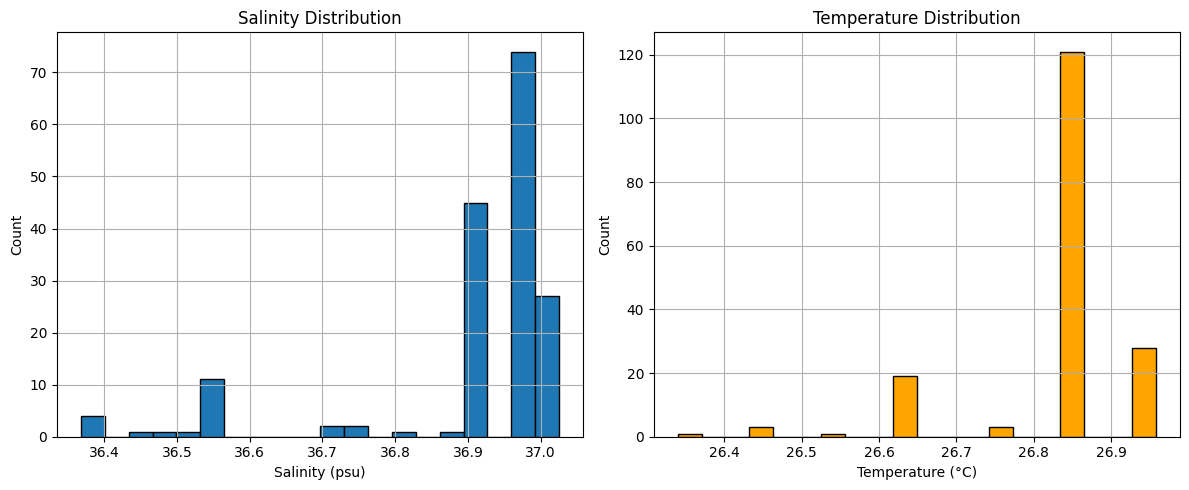

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
combined_df['salinity'].hist(bins=20, edgecolor='k')
plt.title('Salinity Distribution')
plt.xlabel('Salinity (psu)')
plt.ylabel('Count')

plt.subplot(1,2,2)
combined_df['temperature'].hist(bins=20, edgecolor='k', color='orange')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Salinity vs. Temperature (Scatter Plot)

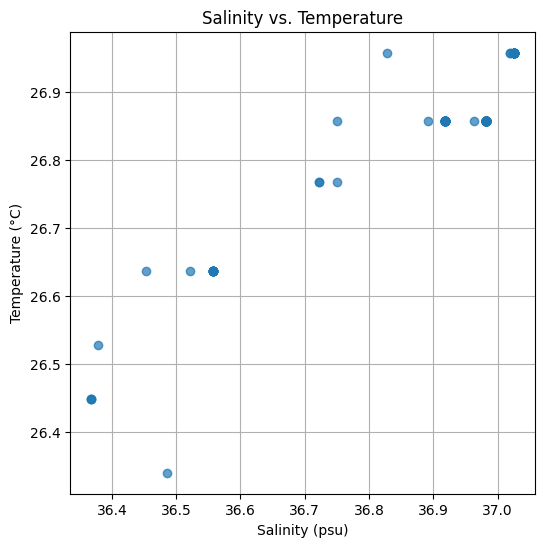

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(combined_df['salinity'], combined_df['temperature'], alpha=0.7)
plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature (°C)')
plt.title('Salinity vs. Temperature')
plt.grid(True)
plt.show()


Temporal Trends

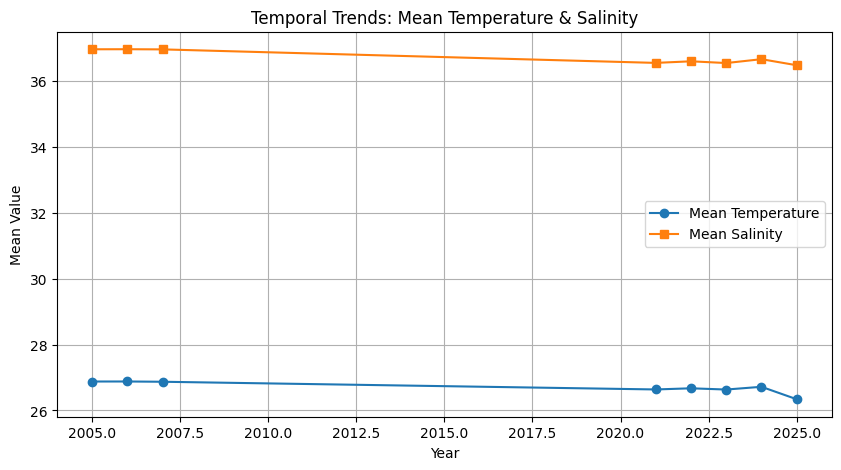

In [ ]:

if 'year' not in combined_df:
    combined_df['year'] = pd.to_datetime(combined_df['time']).dt.year

plt.figure(figsize=(10,5))
plt.plot(combined_df.groupby('year')['temperature'].mean(), label='Mean Temperature', marker='o')
plt.plot(combined_df.groupby('year')['salinity'].mean(), label='Mean Salinity', marker='s')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Temporal Trends: Mean Temperature & Salinity')
plt.grid(True)
plt.show()


 Correlation Coefficient

In [ ]:
print("Correlation between salinity and temperature:")
print(combined_df[['salinity', 'temperature']].corr())


Correlation between salinity and temperature:
             salinity  temperature
salinity      1.00000      0.92986
temperature   0.92986      1.00000


# SDM One Class SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

In [ ]:
features = ['salinity', 'temperature']
df_ml = combined_df.dropna(subset=features)

X = df_ml[features].values


X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma=0.5)
model.fit(X_train_scaled)
df_ml['score'] = model.decision_function(scaler.transform(X))
df_ml['anomaly'] = model.predict(scaler.transform(X))  # +1 normal, -1 outlier

print(df_ml[['salinity', 'temperature', 'score', 'anomaly']].head())
print(df_ml['anomaly'].value_counts())


    salinity  temperature     score  anomaly
0  37.025467    26.958191  0.000176        1
1  36.981316    26.857309  0.000543        1
2  36.918724    26.857309  0.185325        1
3  36.981316    26.857309  0.000543        1
4  36.981316    26.857309  0.000543        1
anomaly
 1    147
-1     23
Name: count, dtype: int64


/tmp/ipython-input-33-3519765360.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['score'] = model.decision_function(scaler.transform(X))
/tmp/ipython-input-33-3519765360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['anomaly'] = model.predict(scaler.transform(X))  # +1 normal, -1 outlier


# Plot in environmental space

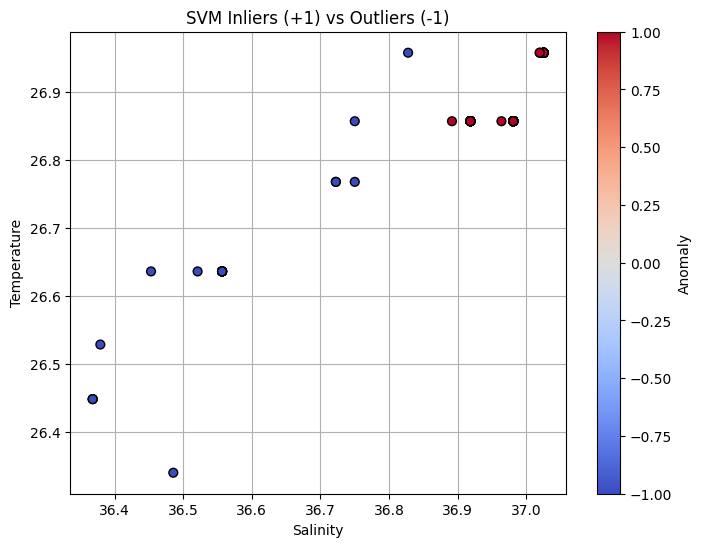

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_ml['salinity'], df_ml['temperature'], c=df_ml['anomaly'], cmap='coolwarm', edgecolor='k', s=40)
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('SVM Inliers (+1) vs Outliers (-1)')
plt.grid(True)
plt.colorbar(label='Anomaly')
plt.show()


# Map anomaly scores

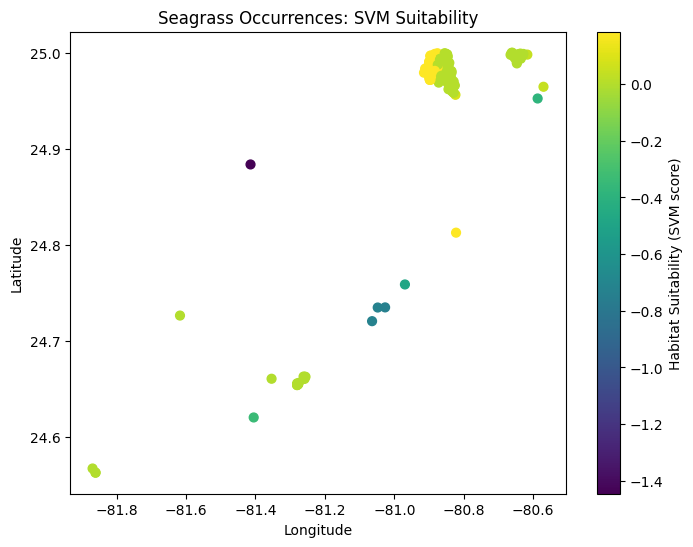

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_ml['lon'], df_ml['lat'], c=df_ml['score'], cmap='viridis', s=40)
plt.colorbar(label='Habitat Suitability (SVM score)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Seagrass Occurrences: SVM Suitability')
plt.show()


# Yearly anomaly counts

anomaly   -1     1
year              
2005     0.0  50.0
2006     0.0  48.0
2007     0.0  47.0
2021     1.0   0.0
2022     8.0   0.0
2023     9.0   1.0
2024     4.0   1.0
2025     1.0   0.0


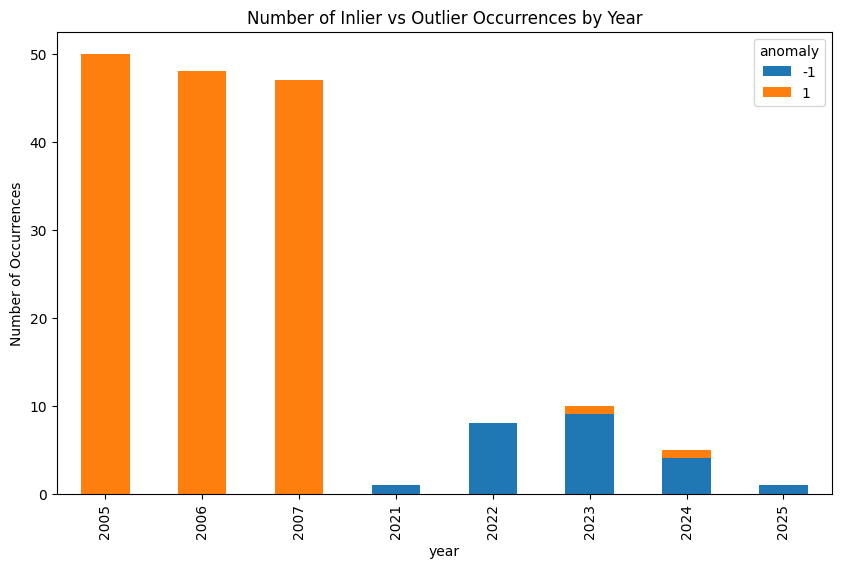

In [ ]:
if 'year' not in df_ml:
    df_ml['year'] = pd.to_datetime(df_ml['time']).dt.year

anomaly_by_year = df_ml.groupby('year')['anomaly'].value_counts().unstack().fillna(0)
print(anomaly_by_year)
anomaly_by_year.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel('Number of Occurrences')
plt.title('Number of Inlier vs Outlier Occurrences by Year')
plt.show()


Plot the SDM Suitability Map

In [ ]:
# print('sal_grid shape:', sal_grid.shape)
# print('sal_lats shape:', sal_lats.shape)
# print('sal_lons shape:', sal_lons.shape)
# print('temp_grid shape:', temp_grid.shape)
# print('temp_lats shape:', temp_lats.shape)
# print('temp_lons shape:', temp_lons.shape)


sal_grid shape: (1, 2041, 4320)
sal_lats shape: (2041,)
sal_lons shape: (4320,)
temp_grid shape: (720, 1440)
temp_lats shape: (720,)
temp_lons shape: (1440,)


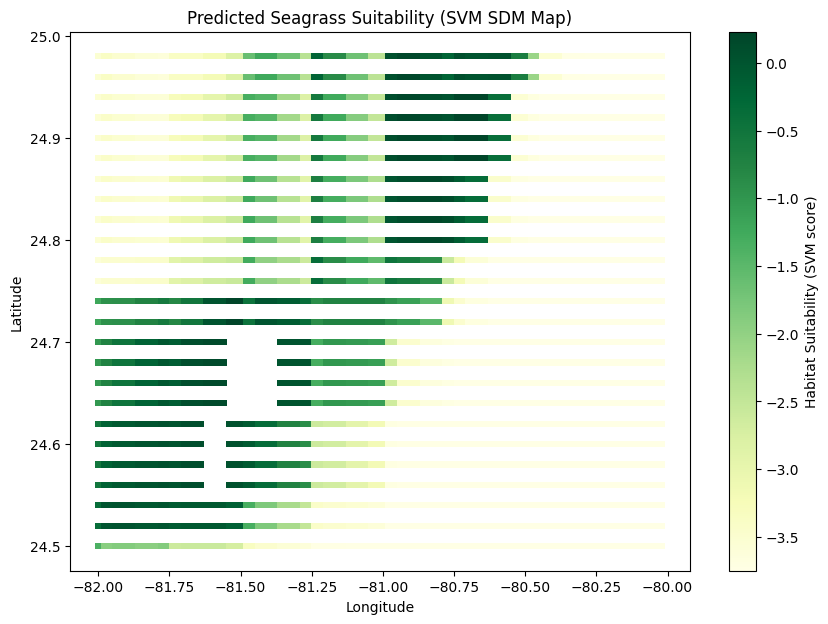

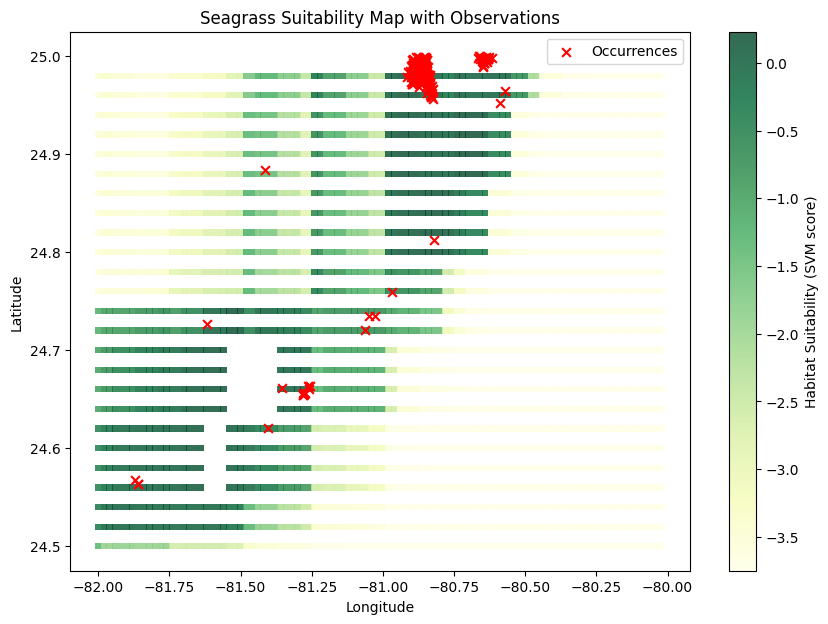

In [ ]:

lon_min, lon_max = -82, -80
lat_min, lat_max = 24.5, 25.0
resolution = 0.02  # degrees
lons = np.arange(lon_min, lon_max, resolution)
lats = np.arange(lat_min, lat_max, resolution)
lon_grid, lat_grid = np.meshgrid(lons, lats)
coords = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])

sal_grid = ds['so'][0, :, :]
sal_lats = ds['latitude'].values
sal_lons = ds['longitude'].values


temp_grid = ds_temp['t_an'][0, 0, :, :]
temp_lats = ds_temp['lat'].values
temp_lons = ds_temp['lon'].values


def nearest_salinity(lon, lat, grid, grid_lons, grid_lats):
    lon_idx = np.abs(grid_lons - lon).argmin()
    lat_idx = np.abs(grid_lats - lat).argmin()
    lon_idx = np.clip(lon_idx, 0, grid.shape[2] - 1)
    lat_idx = np.clip(lat_idx, 0, grid.shape[1] - 1)
    value = grid[0, lat_idx, lon_idx]
    if hasattr(value, 'item'):
        value = value.item()
    elif hasattr(value, 'values'):
        value = value.values
        if np.size(value) == 1:
            value = float(value)
    return value

def nearest_temperature(lon, lat, grid, grid_lons, grid_lats):
    lon_idx = np.abs(grid_lons - lon).argmin()
    lat_idx = np.abs(grid_lats - lat).argmin()
    lon_idx = np.clip(lon_idx, 0, grid.shape[1] - 1)
    lat_idx = np.clip(lat_idx, 0, grid.shape[0] - 1)
    value = grid[lat_idx, lon_idx]
    if hasattr(value, 'item'):
        value = value.item()
    elif hasattr(value, 'values'):
        value = value.values
        if np.size(value) == 1:
            value = float(value)
    return value



salinities = []
temperatures = []

for lon, lat in coords:
    try:
        s = nearest_salinity(lon, lat, sal_grid, sal_lons, sal_lats)
    except Exception as e:
        s = np.nan
    try:
        t = nearest_temperature(lon, lat, temp_grid, temp_lons, temp_lats)
    except Exception as e:
        t = np.nan
    salinities.append(s)
    temperatures.append(t)


grid_df = pd.DataFrame({
    'lon': coords[:, 0],
    'lat': coords[:, 1],
    'salinity': salinities,
    'temperature': temperatures
})

grid_df = grid_df.dropna(subset=['salinity', 'temperature'])


X_grid = grid_df[['salinity', 'temperature']].values
X_grid_scaled = scaler.transform(X_grid)
grid_df['suitability'] = model.decision_function(X_grid_scaled)

plt.figure(figsize=(10,7))
sc = plt.scatter(grid_df['lon'], grid_df['lat'], c=grid_df['suitability'],
                 cmap='YlGn', s=20, marker='s', edgecolor='none')
plt.colorbar(sc, label='Habitat Suitability (SVM score)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Seagrass Suitability (SVM SDM Map)')
plt.show()


plt.figure(figsize=(10,7))
plt.scatter(grid_df['lon'], grid_df['lat'], c=grid_df['suitability'],
            cmap='YlGn', s=20, marker='s', edgecolor='none', alpha=0.8)
plt.colorbar(label='Habitat Suitability (SVM score)')
plt.scatter(df_ml['lon'], df_ml['lat'], c='red', marker='x', s=40, label='Occurrences')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Seagrass Suitability Map with Observations')
plt.show()

In [ ]:
from matplotlib import cm, colors
import folium

m = folium.Map(location=[24.75, -81], zoom_start=9, tiles=None)
folium.TileLayer('Esri.WorldImagery').add_to(m)

norm = colors.Normalize(vmin=grid_df['suitability'].min(), vmax=grid_df['suitability'].max())
cmap = cm.get_cmap('YlGnBu')

for i, row in grid_df.iterrows():
    col = colors.rgb2hex(cmap(norm(row['suitability'])))
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        color=col,
        fill=True,
        fill_opacity=0.45
    ).add_to(m)

for i, row in df_ml.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=0.9
    ).add_to(m)
m

/tmp/ipython-input-57-754546919.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlGnBu')


Spatial and environmental plots show which locations and conditions are flagged as outliers, possibly indicating abnormal events (e.g., die-offs, blooms, extreme conditions).

Yearly anomaly plot reveals that certain years (e.g., 2021, 2022, 2023) have higher proportions of anomalies—potentially corresponding to environmental stress events.

Anomaly points can be further investigated against known disturbances (hurricanes, algal blooms, etc.) to provide ecological insight and support management.



Results:

Most points (~86%) are classified as “normal” based on environmental conditions.

A subset of points (23 out of 170) are flagged as anomalies (outliers) by the SVM.

